## ***Sentiment analysis of IMDb reviews using a self-defined LSTM***

#### Long Short-Term Memory (LSTM) networks are a type of Recurrent Neural Network (RNN) that are particularly well-suited for sequence prediction problems, such as sentiment analysis on the IMDB dataset. Here's how LSTMs solve the problem of sentiment analysis:

**Problem Representation**
1. Data Representation:

* Input Data: The IMDB dataset consists of movie reviews, which are sequences of words. These reviews are encoded as sequences of integers, where each integer represents a word index.
* Labels: Each review is labeled as either positive (1) or negative (0).

2. Preprocessing:

* Vocabulary Limitation: The dataset is limited to the top max_vocab_size most frequent words to reduce the complexity of the model and save running time.
* Padding/Truncating: Reviews are padded or truncated to a fixed length (review_length) to ensure uniform input size for the LSTM model.

**Main Steps in Algorithm Implementation**
1) Loading and Preprocessing Data:

* Loading Data: The IMDB dataset is loaded with a constraint on the vocabulary size.
* Padding/Truncating: Reviews are padded or truncated to a fixed length to ensure uniform input size.

2) Building the LSTM Model:

* Embedding Layer: Converts word indices into dense vectors of fixed size (word_embedding_dims). This layer helps in capturing the semantic meaning of words.
* LSTM Layer: Processes the sequence of word vectors. LSTMs are capable of learning long-term dependencies, which is crucial for understanding the context in a review.
* Dropout Layers: Added to prevent overfitting by randomly dropping units during training.
* Dense Layer: A fully connected layer with a sigmoid activation function to output the final sentiment prediction (positive or negative).

3) Compiling the Model:

* Loss Function: Binary cross-entropy is used as the loss function since this is a binary classification problem.
* Optimizer: Adam optimizer is used for training the model.
* Metrics: Accuracy is used as the evaluation metric.

4) Training the Model:

* The model is trained on the training dataset, where it learns to map sequences of word indices to sentiment labels.
* Training Parameters: The number of epochs, batch size, learning rate and validation split are set to train the model effectively.

5) Evaluating the Model:

* The model's performance is evaluated on the testing dataset using metrics like accuracy and classification report.
* The accuracy and loss curves are plotted to visualize the model's performance during training.

**Importing all required dependencies**

In [52]:
import tensorflow as tf #import TensorFlow library
import numpy as np #for effeicient numerical operations
import matplotlib.pyplot as plt #to plot graphs and charts
from keras.preprocessing import sequence  #to pad/truncate sequences
from keras.datasets import imdb #import IMDB dataset
from keras.models import Sequential #import Sequential model
from keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional, BatchNormalization #import Dense, Embedding, LSTM, Bidirectional, Batch normalisation & Dropout layers
from keras.optimizers import Adam #import Adam optimizer
from sklearn.metrics import classification_report #import classification_report to evaluate the model

**This function loads the IMDB movie review dataset while limiting the vocabulary size to a specified maximum 'max_vocab_size'. This parameter determines the maximum number of most frequent words to include in the dataset, effectively filtering out less common words.**

**This returns a tuple containing the training and testing datasets, where each dataset is itself a tuple of numpy arrays: (x_train, y_train) for the training data and (x_test, y_test) for the testing data.**

In [9]:
def imdb_dataset(max_vocab_size=20000):
    """
    Loads the IMDB dataset with a constraint on the vocabulary size.

    Args:
        max_vocab_size (int): The maximum number of words to include in the dataset. Only the top `max_vocab_size` most frequent words will be kept.

    Returns:
        tuple: A tuple containing the training and testing datasets.
    """

    print('Loading IMDB dataset...')
    return imdb.load_data(num_words=max_vocab_size) #load IMDB dataset by constraining reviews to top 20,000 words

***Reviews in this dataset have been encoded as sequences of integers. To covnert these back into comprehensible form, the imdb module provides the function 'get_word_index()'***

**The function below modifies the word index dictionary, to include special characters for padding, start of sequence, unknown words, and unused token.**

* These special tokens are introduced during preprocessing to help the model handle padding, unknown words, and the start of a sequence.

1) PAD : Used for padding short sequences to ensure uniform length across all sequences.
2) START : Used to indicate the start of a sequence.
3) UNKNOWN : Used to represent words that are not in the vocabulary.
4) UNUSED : A placeholder for potential future use.

In [10]:
def mod_word_idx_dict():
    """
    Modifies the word index dictionary from the IMDb dataset to include special tokens.
    The function performs the following steps:
    1. Retrieves the original word index dictionary from the IMDb dataset.
    2. Adjusts the dictionary to include special tokens by incrementing all existing values by the number of special tokens minus one.
    3. Adds special tokens ('<PAD>', '<START>', '<UNKNOWN>', '<UNUSED>') to the dictionary with their respective indices.

    Returns:
        dict: A modified word index dictionary with special tokens included.
    """

    word_index = imdb.get_word_index() #get word index - a dictionary mapping words to an integer index

    #adjusting the dictionary to include special tokens/characters
    special_tokens = ['<PAD>', '<START>', '<UNKNOWN>', '<UNUSED>'] #special tokens
    num_special_tokens = len(special_tokens) #number of special tokens
    
    #the original word_index dictionarys's values start from 1, but the modified one's value is set to start from 0.
    #therefore, we need to increment all values by num_special_tokens-1

    word_index = {key:value+(num_special_tokens-1) for key,value in word_index.items()} #increment all values by num_special_tokens-1

    for i in range(num_special_tokens):
        word_index[special_tokens[i]] = i #add special tokens to the dictionary

    return word_index


**The function defined below takes the integer-encoded reviews and converts them back into the original words.**

In [11]:
def decode_review(review, mod_word_index):
    """
    Decodes a review represented as a list of integers into a human-readable string.

    Args:
        review (list of int): The review to decode, where each integer represents a word index.
        mod_word_index (dict): A dictionary mapping words and special tokens to their corresponding integer indices.
        
    Returns:
        str: The decoded review as a string, with words separated by spaces. If an integer index
             is not found in the word_index, it is replaced by '?'.
    """

    #create a dictionary mapping integer indices to words
    reverse_word_index = {value:key for key,value in mod_word_index.items()}
    #IMP_NOTE: review is not a text! It is a list of integers
    return ' '.join([reverse_word_index.get(i,'?') for i in review]) #convert list of integers to text seperated by space, '?' is a fallback if an index is not found

**The functions defined below are data exploration functions that help us understand the dataset better.**

***plot_review_len()***

* Plots a histogram of the lengths of the reviews in the dataset. This helps us understand the distribution of review lengths and decide on the maximum sequence length to use for padding.

In [12]:
def plot_review_len(x_data): #x_train or x_test
    """
    Plots a histogram of the lengths of reviews in the given dataset.

    Args:
        x_data (numpy array): A numpy array of integers, where each row represents a review consisting of a sequence of word indices.
    """

    #get the lengths of all reviews
    reviews_lengths = [len(review) for review in x_data]

    #plot histogram of review lengths
    plt.figure(figsize=(10, 6))
    plt.hist(x=reviews_lengths, bins=range(min(reviews_lengths), max(reviews_lengths) + 50, 50), color='blue', edgecolor='black')
    plt.title('Histogram: Review Lengths')
    plt.xlabel('Review Length')
    plt.ylabel('Frequency')
    plt.show()

***stats_reviews()***

* Prints the following statistics about the dataset:
    1) Number of reviews
    2) Average review length
    3) Maximum review length
    4) Minimum review length
    5) Standard deviation of review lengths

In [13]:
def stats_reviews(x_train, x_test):
    """
    Calculate and print statistics for review lengths in training and testing datasets.

    Args:
        x_train (numpy array): Array of reviews in the training dataset.
        x_test (numpy array): Array of reviews in the testing dataset.

    Statistics Calculated:
        1. Number of reviews in training and testing datasets.
        2. Average review length in training and testing datasets.
        3. Maximum review length in training and testing datasets.
        4. Minimum review length in training and testing datasets.
        5. Standard deviation of review lengths in training and testing datasets.

    Prints:
        - Number of reviews in training and testing datasets.
        - Average review length in training and testing datasets.
        - Maximum review length in training and testing datasets.
        - Minimum review length in training and testing datasets.
        - Standard deviation of review lengths in training and testing datasets.
    """
    # 1)number of reviews in training and testing datasets
    num_train_reviews = len(x_train) #number of reviews in training dataset
    num_test_reviews = len(x_test) #number of reviews in testing dataset

    train_rev_len_list = [len(review) for review in x_train] #list of lengths of reviews in training dataset
    test_rev_len_list = [len(review) for review in x_test] #list of lengths of reviews in testing dataset

    # 2)average review length in training and testing datasets
    avg_train_rev_len = np.mean(train_rev_len_list) #average review length in training dataset
    avg_test_rev_len = np.mean([test_rev_len_list]) #average review length in testing dataset

    # 3)maximum review length in training and testing datasets
    max_train_rev_len = np.amax(train_rev_len_list) #maximum review length in training dataset
    max_test_rev_len = np.amax(test_rev_len_list) #maximum review length in testing dataset

    # 4)minimum review length in training and testing datasets
    min_train_rev_len = np.amin(train_rev_len_list) #minimum review length in training dataset       
    min_test_rev_len = np.amin(test_rev_len_list) #minimum review length in testing dataset

    # 5)standard deviation of review lengths in training and testing datasets
    std_train_rev_len = np.std(train_rev_len_list) #standard deviation of review lengths in training dataset    
    std_test_rev_len = np.std(test_rev_len_list) #standard deviation of review lengths in testing dataset

    print("\nLoading Review Statistics...")
    print("\nTraining Dataset:")
    print("Number of reviews in training dataset:", num_train_reviews)
    print("Average review length in training dataset:", avg_train_rev_len)
    print("Maximum review length in training dataset:", max_train_rev_len)
    print("Minimum review length in training dataset:", min_train_rev_len)
    print("Standard deviation of review lengths in training dataset:", std_train_rev_len)

    print("\nTesting Dataset:")
    print("Number of reviews in testing dataset:", num_test_reviews)
    print("Average review length in testing dataset:", avg_test_rev_len)
    print("Maximum review length in testing dataset:", max_test_rev_len)
    print("Minimum review length in testing dataset:", min_test_rev_len)
    print("Standard deviation of review lengths in testing dataset:", std_test_rev_len)

***rand_review()***
* Prints out a review in its native integer-encoded form and its corresponding original human readble form.

In [14]:
def rand_review(x_data, y_data, mod_word_index):
    """
    Prints a random review and its sentiment from the provided datasets.

    Args:
        x_data (numpy array): Numpy array of integer-encoded reviews.
        y_data (numpy array): Numpy array of sentiment labels corresponding to the reviews.
        mod_word_index (dict): A dictionary mapping words and special tokens to their corresponding integer indices.

    Prints:
        - Integer list representation of a randomly selected review.
        - Sentiment label of the selected review.
        - Decoded text of the selected review.
        - Sentiment label name of the selected review.
    """
    class_label_names = ['Negative', 'Positive'] #class label names
    x_rand_int = np.random.randint(0, len(x_data)) #generate a random integer between 0 and the number of elements in x_data or y_data

    print("\n----Integer list representation----") #print the integer-encoded list representation of the review
    #! side note: typecasting to string is necessary because the list of integers is not a string and cannot be concatenated with a string
    print("\tReview text: " + str(x_data[x_rand_int]))
    print("\tReview sentiment: " + str(y_data[x_rand_int]))

    print("\n----Decoded review----") #print the decoded review
    print("\tReview text: " + decode_review(x_data[x_rand_int], mod_word_index))
    print("\tReview sentiment: " + class_label_names[y_data[x_rand_int]])

**The function below perform data preprocessing tasks.**
* The function 'preprocess_data()' preprocesses the data by performing the following tasks:
    1) Truncate reviews longer than 'max_len' words.
    2) Pad reviews shorter than 'max_len' words.

* These operations make sure that all reviews are of the same length, which is required by the LSTM model.

In [15]:
def preprocess_data(x_train, x_test, review_length=500):
    """
    Preprocesses the training and testing datasets by padding or truncating reviews to a fixed length.

    Args:
        x_train (numpy array): The training dataset containing reviews.
        x_test (numpy array): The testing dataset containing reviews.
        review_length (int, optional): The fixed length to which reviews will be padded or truncated. Default is 500.

    Returns:
        tuple: A tuple containing the preprocessed training and testing datasets.
    """
    #padding/truncating reviews to a fixed length
    #padding - happens when the review length is less than the fixed length
    #truncating - happens when the review length is greater than the fixed length
    x_train = sequence.pad_sequences(x_train, maxlen=review_length, truncating='pre', padding='pre') #pad/truncate reviews from the beginning in training dataset
    x_test = sequence.pad_sequences(x_test, maxlen=review_length, truncating='pre', padding='pre') #pad/truncate reviews from the beginning in testing dataset

    #review if the padding/truncating is done correctly
    print("\nReview after padding/truncating:")
    print("Training dataset: ", x_train.shape) #print the shape of the training dataset; should be (25000, 500)
    print("Testing dataset: ", x_test.shape) #print the shape of the testing dataset; should be (25000, 500)

    return x_train, x_test

**The function below defines the LSTM model.**

* The model consists of an embedding layer, 2 Dropout layers, an LSTM layer, and a dense layer with a sigmoid activation function. 
* The model is compiled with the binary cross-entropy loss function and the Adam optimizer.
* Layer information:
    1) Embedding layer: Embeddings are spatial mappings of words in a continuous vector space. Semantically similar words are closer in the vector space.This spatial mapping is learned during the training process.
    2) Dropout layers: These layers help prevent overfitting by randomly dropping a set of neurons from input and hidden layers during training.
    3) LSTM layer: This layer processes the sequence of word vectors and returns the output at each time step.
        * A bidirectional LSTM processes the input sequence in both forward and backward directions, capturing dependencies in both directions.
    4) Batch Normalization: This layer helps stabilize and regularize the training process.
    5) Dense layer: This layer produces the final output of the model.

    

In [131]:
def build_neural_net(word_embedding_dims=50, max_vocab_size=20000, review_length=500, learning_rate=0.0001):
    """
    Builds and compiles a neural network model for text classification using Keras.

    Args:
        word_embedding_dims (int): The dimension of the word embeddings. Default is 50.
        max_vocab_size (int): The maximum size of the vocabulary. Default is 20000.
        review_length (int): The length of the input sequences (reviews). Default is 500.
        learning_rate (float): The learning rate for the Adam optimizer. Default is 0.001.

    Returns:
        keras.models.Sequential: A compiled Keras Sequential model.
    """
    model = Sequential() #create a Sequential model

    #add an embedding layer
    model.add(
        Embedding(
            input_dim=max_vocab_size, #input dimension
            output_dim=word_embedding_dims, #output dimension
            input_length=review_length #input length
        )
    )

    #add a Dropout layer
    model.add(
        Dropout(rate=0.4) #dropout rate ((rate*100)% of the input units are randomly dropped)
    )

    #add a Bidirectional LSTM layer
    model.add(
        Bidirectional(LSTM(units=16)) #number of units
    )

    #add a BatchNormalization layer
    model.add(
        BatchNormalization() 
    )

    #add a 2nd Dropout layer
    model.add(
        Dropout(rate=0.5) #dropout rate
    )

    #add a Dense layer
    model.add(
        Dense(
            units=1, #number of units
            activation='sigmoid' #activation function
        ) 
    )

    #compile the model
    model.compile(
        loss='binary_crossentropy', #loss function
        optimizer=Adam(learning_rate), #optimizer
        metrics=['accuracy'] #evaluation metrics
    )

    #force the model to build by providing an input shape 
    model.build(input_shape=(None, review_length))

    #display the model summary
    model.summary() 

    return model

**This function trains the model**

#### While training, I got stuck with the overfitting issue even after implementing the dropout layers. I tried to tune the hyperparameters like learning rate, batch size, and the number of epochs, but the model was still overfitting. 

#### To overcome this issue, I decided to implement a learning rate scheduler that reduces the learning rate when the validation loss does not improve for a certain number of epochs. This helps the model converge better and avoid overfitting.

***The callback monitors the validation loss (in my case), and if no improvement is seen for a "patience" number of epochs, the learning rate is reduced by the factor defined.***

Reference - https://keras.io/api/callbacks/reduce_lr_on_plateau/

In [132]:
def lr_scheduler(monitored_metric='val_loss', factor=0.5, patience=3, min_lr=0.0000001):
    """
    Creates a learning rate scheduler callback that reduces the learning rate when a monitored metric has stopped improving.

    Args:
        monitored_metric (str): The metric to monitor. Default is 'val_loss'.
        factor (float): The factor by which the learning rate will be reduced. new_lr = lr * factor. Default is 0.5.
        patience (int): Number of epochs with no improvement after which learning rate will be reduced. Default is 2.
        min_lr (float): The minimum learning rate. Default is 0.000001.

    Returns:
        tf.keras.callbacks.ReduceLROnPlateau: A callback to reduce learning rate when the monitored metric has stopped improving.
    """
    
    #add a callback to reduce learning rate when the validation loss has stopped improving
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor = monitored_metric, #the metric to keep an eye on
        factor = factor, #fraction by which learning rate is reduced (new_lr = lr * factor)
        patience = patience, #number of epochs with no improvement after which learning rate will be reduced
        min_lr = min_lr, #minimum learning rate
        verbose = 1
    )
    
    return reduce_lr

In [133]:
def train_neural_net(model, x_train, y_train, lr_scheduler):
    """
    Trains a neural network model using the provided training data and labels.
    
    Args:
        model (keras.models.Sequential): The neural network model to be trained.
        x_train (numpy array): Training data.
        y_train (numpy array): Training labels.
        
    Returns:
        history: A History object. Its History.history attribute is a record of training loss values 
                 and metrics values at successive epochs, as well as validation loss values and 
                 validation metrics values.
    """
    
    #train the model on x_train and y_train
    history = model.fit(
        x_train, #training data
        y_train, #training labels
        batch_size=512, #batch size
        epochs=50, #number of epochs
        validation_split=0.2, #this fraction will be kept apart for validation at the end of each epoch
        verbose=1, 
        callbacks=[lr_scheduler] #callback to reduce learning rate
    )

    return history

**The function plots the training history of the model.**

* The training history includes the loss and accuracy on the training and validation sets for each epoch.
* This function helps visualize the model's performance during training and identify potential issues like overfitting or underfitting.

In [134]:
#The plotting function
def plot_loss_acc(history):
    """
    Plots the training and validation accuracy and loss over epochs.

    Args:
      history (History): A History object returned by the fit method of a Keras model. 
              It contains the training, validation accuracy and loss for each epoch.
    """
    train_acc = history.history['accuracy'] #training accuracy
    val_acc = history.history['val_accuracy'] #validation accuracy
    train_loss = history.history['loss'] #training loss
    val_loss = history.history['val_loss'] #validation loss
    epochs_range = range(1, len(train_acc)+1) #range of epochs

    #accuracy plot
    plt.figure(figsize=(10,6))
    plt.plot(epochs_range, train_acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    #loss plot
    plt.figure(figsize=(10,6))
    plt.plot(epochs_range, train_loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

**This function evaluates the model on the test data and prints the classification report**
* The classification report includes metrics like precision, recall, and F1-score for both classes (positive and negative).

In [135]:
def gen_classification_report(model, x_test, y_test):
    """
    Generates a classification report for a trained model on test data.

    Args:
        model (keras.models.Sequential): The trained neural network model.
        x_test (numpy array): The test data.

    Returns:
        sklearn.metrics.ClassificationReport: A classification report containing precision, recall, F1-score, and support.
    """
    #predict the sentiment of reviews in the test dataset
    y_pred = model.predict(x_test)

    #convert the predicted probabilities to binary values
    y_pred = np.where(y_pred > 0.5, 1, 0)

    #classification report
    return classification_report(y_test, y_pred, target_names=['Negative', 'Positive'])

**This function encapulates all the above functions and runs the entire pipeline.**

In [136]:
def main():
    #load the IMDB dataset
    (x_train, y_train), (x_test, y_test) = imdb_dataset()

    #modify the word index dictionary to include special tokens
    mod_word_index = mod_word_idx_dict()

    #plot histogram of review lengths for training dataset and testing dataset
    plot_review_len(x_train)
    plot_review_len(x_test)

    #calculate and print statistics for review lengths in training and testing datasets
    stats_reviews(x_train, x_test)

    #print a random review and its sentiment from the provided datasets
    rand_review(x_train, y_train, mod_word_index)

    #preprocess the training and testing datasets
    x_train, x_test = preprocess_data(x_train, x_test)

    #build and compile a neural network model for text classification
    #learning_rate = 0.0005
    model = build_neural_net()

    #train the neural network model
    print("\nTraining the neural network model...")
    history = train_neural_net(model, x_train, y_train, lr_scheduler())

    #plot the training and validation accuracy and loss over epochs
    plot_loss_acc(history)

    #generate a classification report for the trained model on test data
    report = gen_classification_report(model, x_test, y_test)
    print("\nClassification Report:")
    print(report)

Loading IMDB dataset...


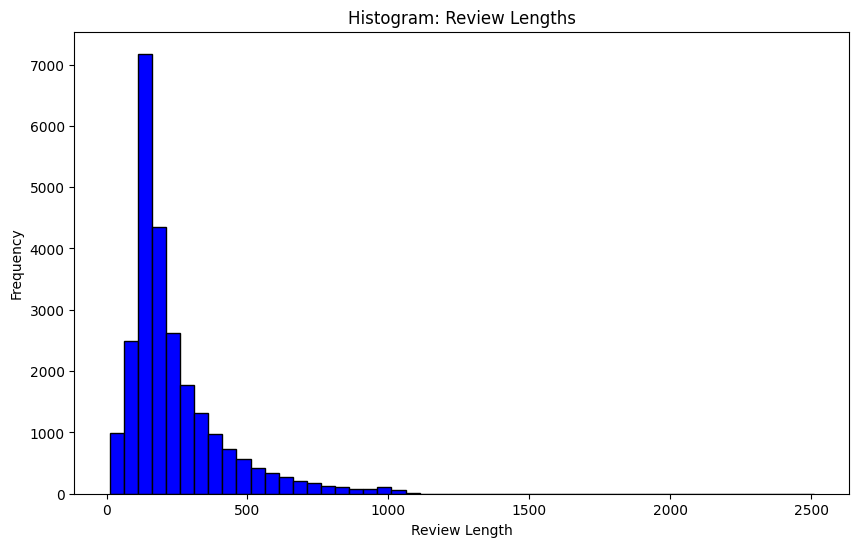

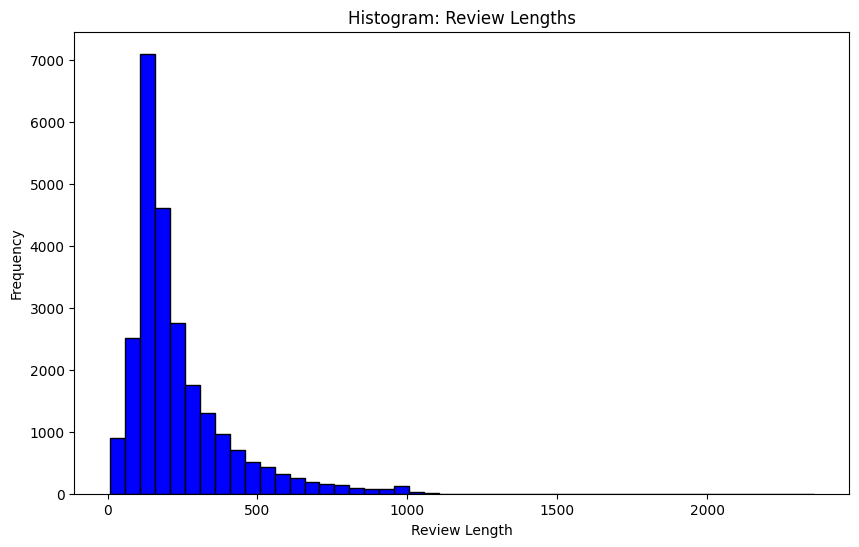


Loading Review Statistics...

Training Dataset:
Number of reviews in training dataset: 25000
Average review length in training dataset: 238.71364
Maximum review length in training dataset: 2494
Minimum review length in training dataset: 11
Standard deviation of review lengths in training dataset: 176.49367364852034

Testing Dataset:
Number of reviews in testing dataset: 25000
Average review length in testing dataset: 230.8042
Maximum review length in testing dataset: 2315
Minimum review length in testing dataset: 7
Standard deviation of review lengths in testing dataset: 169.16108731726692

----Integer list representation----
	Review text: [1, 14, 286, 163, 11, 4506, 45, 24, 163, 150, 10, 10, 1025, 6, 176, 7, 85, 84, 146, 24, 6397, 4, 22, 88, 12, 9, 966, 7901, 13, 3194, 510, 15, 227, 42, 247, 13, 510, 4, 2097, 12, 12218, 11, 616, 6090, 84, 146, 6397, 12, 88, 12, 9, 862, 398, 5, 917, 10, 10, 4, 64, 66, 906, 109, 9, 2, 63, 698, 84, 2476, 153, 154, 80, 10175, 1241, 237, 29, 16, 6, 1640, 

c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_20 (Embedding)        │ (None, 500, 50)        │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 500, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_20                │ (None, 32)             │         8,576 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,008,737 (3.85 MB)

 Trainable params: 1,008,673 (3.85 MB)

 Non-trainable params: 64 (256.00 B)


Training the neural network model...
Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 120s 3s/step - accuracy: 0.4989 - loss: 0.7471 - val_accuracy: 0.5342 - val_loss: 0.6928 - learning_rate: 1.0000e-04
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 114s 3s/step - accuracy: 0.5223 - loss: 0.7249 - val_accuracy: 0.5672 - val_loss: 0.6921 - learning_rate: 1.0000e-04
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 122s 3s/step - accuracy: 0.5373 - loss: 0.7070 - val_accuracy: 0.5912 - val_loss: 0.6911 - learning_rate: 1.0000e-04
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 136s 3s/step - accuracy: 0.5640 - loss: 0.6924 - val_accuracy: 0.6074 - val_loss: 0.6897 - learning_rate: 1.0000e-04
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 138s 3s/step - accuracy: 0.5830 - loss: 0.6764 - val_accuracy: 0.6292 - val_loss: 0.6876 - learning_rate: 1.0000e-04
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 138s 3s/step - accuracy: 0.6036 - loss: 0.6622 - val_accuracy: 0.6462 - val_loss: 0.6846 - learning_rate: 1.0000e-04
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━

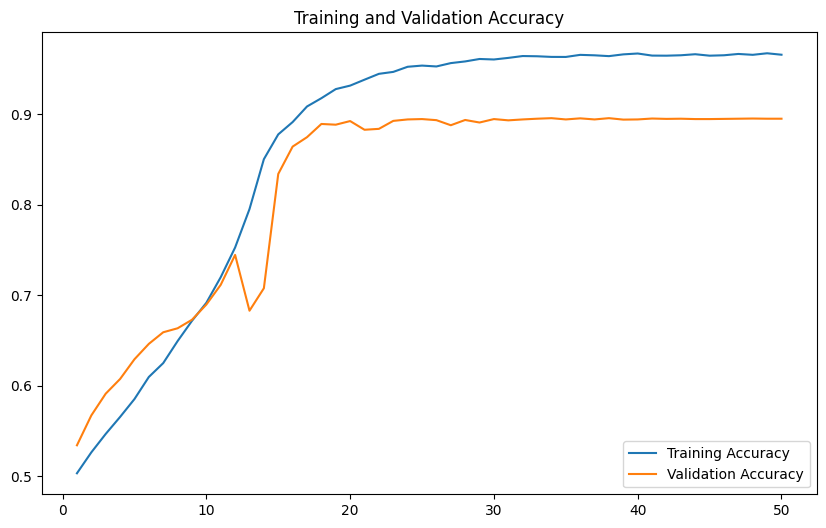

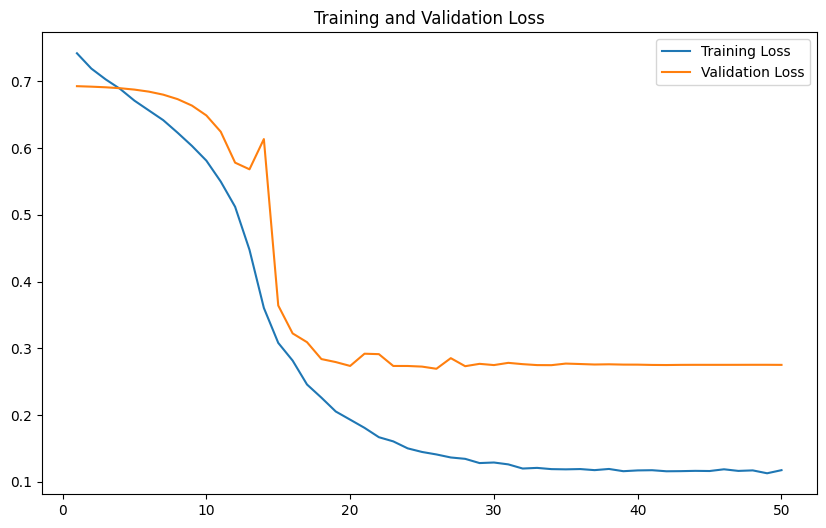

782/782 ━━━━━━━━━━━━━━━━━━━━ 54s 69ms/step

Classification Report:
              precision    recall  f1-score   support

    Negative       0.87      0.89      0.88     12500
    Positive       0.88      0.86      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



In [137]:
if __name__ == "__main__":
    main()